In [1]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

sys.path.append('/Applications/OpenFUSIONToolkit/python')
from OpenFUSIONToolkit.TokaMaker import TokaMaker, load_gs_mesh, gs_Domain, read_eqdsk

from omfit_classes.omfit_eqdsk import boundaryShape

In [2]:
def resize_polygon(points, dx):
    new_points = np.empty(np.shape(points))
    for i in range(np.shape(points)[0]):
        if i==0:
            last = points[-1,:]
            next = points[i+1,:]
        elif i == np.shape(points)[0]-1:
            last = points[i-1,:]
            next = points[0,:]
        else:
            next = points[i+1,:]
            last = points[i-1,:]
        par = points[i,:]-last
        par/= np.linalg.norm(par)
        perp = np.array([par[1], -par[0]])
        temp = points[i,:] + perp*dx
        par_2 = next-points[i,:]
        par_2/= np.linalg.norm(par_2)
        perp_2 = [par_2[1], -par_2[0]]
        new_points[i, :] = temp + dx/np.dot(perp_2,par)*par  + par*dx/np.dot(par_2,perp)*np.dot(par_2,par)
    return new_points

In [3]:
def corners(r,z,dr,dz):
    rs = np.array([r+dr/2, r+dr/2, r-dr/2, r-dr/2, r+dr/2])
    zs = np.array([z+dz/2, z-dz/2, z-dz/2, z+dz/2, z+dz/2])
    return np.column_stack((rs,zs))

In [4]:
def closest(plasma, lim):
    min = 1E10
    point = [0,0]
    for i in range(np.size(lim[:,0])):
        distances = np.sqrt((plasma[:,0]-lim[i,0])**2 +(plasma[:,1]-lim[i,1])**2 )
        if np.min(distances)<min:
            min = np.min(distances)
            point = plasma[np.argmin(distances),:]
    return point, min*100

In [5]:
r,z,zeff= boundaryShape(kapu = 1.55, kapl = 1.55, delu = -0.4, dell = -0.4, zetail = -.03, zetaiu = -.03, zetaou = -.03, zetaol = -.03, a = 0.413, eps = 0.413/0.85, zoffset = 0, upnull = False, lonull = False, npts = 8)
lim1 = np.column_stack((r,z))
vv1 = resize_polygon(lim1, 0.03)

lim2 = resize_polygon(lim1, -0.05)
vv2 = resize_polygon(lim2, 0.06)

lim3 = resize_polygon(lim1, -0.1)
vv3 = resize_polygon(lim3, 0.03)

In [6]:
coils = {
    'CS0': {'rc': 0.375, 'zc': -.54, 'w': 0.05, 'h': 0.35},
    'CS1': {'rc': 0.375, 'zc': 0, 'w': 0.05, 'h': 0.7},
    'CS2': {'rc': 0.375, 'zc': .54, 'w': 0.05, 'h': 0.35},

    'EF0U': {'rc': .588, 'zc': 0.53, 'w': 0.1, 'h': 0.1},
    'EF1U': {'rc': 1.115, 'zc': 0.745, 'w': 0.1, 'h': 0.1},
    'EF2U': {'rc': 1.245, 'zc': 0.645, 'w': 0.1, 'h': 0.1},
    'EF3U': {'rc': 1.7, 'zc': 0.4, 'w': .15, 'h': .15},

    'EF0L': {'rc': .588, 'zc': -0.53, 'w': 0.1, 'h': 0.1},
    'EF1L': {'rc': 1.115, 'zc': -0.745, 'w': 0.1, 'h': 0.1},
    'EF2L': {'rc': 1.245, 'zc': -0.645, 'w': 0.1, 'h': 0.1},
    'EF3L': {'rc': 1.7, 'zc': -0.4, 'w': .15, 'h': .15},
  
}

In [7]:
## Define mesh resolution in each region
plasma_resolution = 0.02
coil_resolution = 0.04
vv_resolution = 0.03
vac_resolution = 0.075

In [8]:
# Create a G-S domain
gs_mesh = gs_Domain()
# Define region information for mesh
gs_mesh.define_region('air',vac_resolution,'boundary')
gs_mesh.define_region('plasma',plasma_resolution,'plasma')
gs_mesh.define_region('vv',vv_resolution,'conductor',eta=1e-6)
# Define each of the coils
for key, coil in coils.items():
    gs_mesh.define_region(key,coil_resolution,'coil')

In [9]:
# Define vaccum vessel geometry
gs_mesh.add_annulus(lim2,'plasma',vv2,'vv',parent_name='air')
# Define the shape of the coils
for key, coil in coils.items():
    gs_mesh.add_rectangle(coil['rc'],coil['zc'],coil['w'],coil['h'],key,parent_name='air')

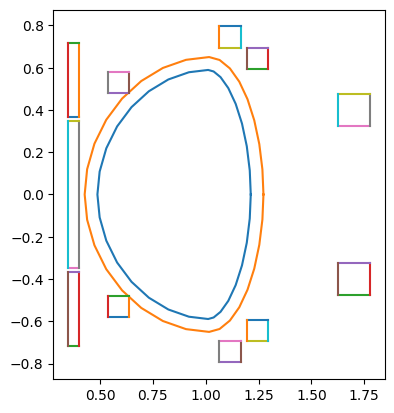

In [10]:
## Plot geometry
fig, ax = plt.subplots(1,1)
for region in gs_mesh.regions:
    region.plot_segments(fig,ax)
ax.set_aspect('equal','box')

In [11]:
#Create mesh
mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()
coil_dict = gs_mesh.get_coils()
cond_dict = gs_mesh.get_conductors()

Assembling regions:
  # of unique points    = 514
  # of unique segments  = 50
Generating mesh:
  # of points  = 4019
  # of cells   = 7930
  # of regions = 14


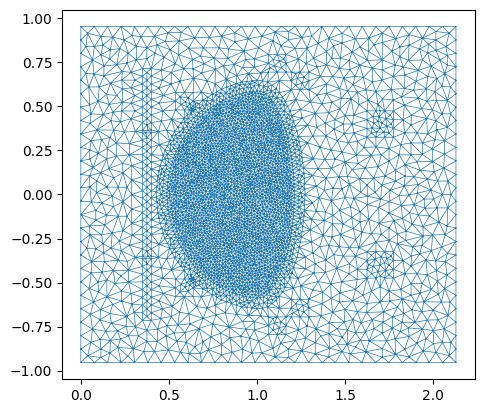

In [12]:
# Plot mesh
fig, ax = plt.subplots()
plt.gca().set_aspect(aspect = 1)
ax.triplot(mesh_pts[:,0],mesh_pts[:,1], lw = 0.5)

In [13]:
mygs = TokaMaker()
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict)
mygs.setup(order = 2, F0 =0.85*3) ## F0 = R0 * B0

#----------------------------------------------
OpenFUSIONToolkit Initialized
Development branch:   main
Revision id:          11ca7a7
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  4.064E+00
    # of points  =    4019
    # of edges   =   11948
    # of cells   =    7930
    # of boundary points =     106
    # of boundary edges  =     106
    # of boundary cells  =     106
  Resolution statistics:
    hmin =  4.899E-03
    hrms =  3.647E-02
    hmax =  1.085

In [14]:
coil_reg_mat = np.zeros((mygs.ncoils+1,mygs.ncoils+1), dtype=np.float64)
targets = np.zeros(mygs.ncoils+1)
coil_weights = 0.5*np.ones(mygs.ncoils+1)

#Set target values for CS coils
coil_reg_mat[0,0] = 1
coil_reg_mat[1,1] = 1
coil_reg_mat[2,2] = 1
targets[0] = -5E5
targets[1] = -5E5 
targets[2] = -5E5

#Enforce up/down symmetry in PF coils
coil_reg_mat[3,3] = 1
coil_reg_mat[3,7] = -1
coil_reg_mat[4,4] = 1
coil_reg_mat[4,8] = -1
coil_reg_mat[5,5] = 1
coil_reg_mat[5,9] = -1
coil_reg_mat[6,6] = 1
coil_reg_mat[6,10] = -1

mygs.set_coil_reg(coil_reg_mat, targets, coil_weights)

#Set upper bound on coil currents
coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
coil_bounds[:,0] = -1.E11; coil_bounds[:,1] = 1.E11
mygs.set_coil_bounds(coil_bounds)


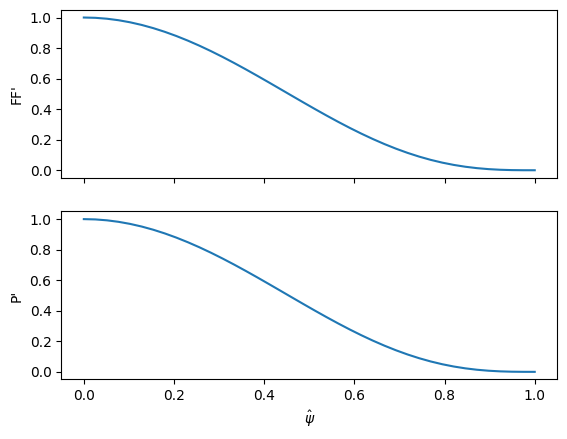

In [15]:
# Define shape of P' anf FF' profiles

n_sample = 40
psi_sample = np.linspace(0.0,1.0,n_sample)

# Set F*F' profile
alpha = 2
gamma = 3
ffp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)

# Set P' profile
alpha = 2
gamma = 3
pp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)

fig, ax = plt.subplots(2,1,sharex=True)
# Plot F*F'
ax[0].plot(ffp_prof['x'],ffp_prof['y'])
ax[0].set_ylabel("FF'")
# Plot P'
ax[1].plot(pp_prof['x'],pp_prof['y'])
ax[1].set_ylabel("P'")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")

mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

In [16]:
#Define global quantities
Ip_target = 1E6
mygs.set_targets(Ip = Ip_target, Ip_ratio=1) #Can change poloidal beta by modifying Ip_ratio target

In [17]:
##Set shape targets
kappa = 1.9
delta = -0.5

r, z, zeff = boundaryShape(kapu = kappa, kapl = kappa, delu = delta, dell = delta, zetail = 0, zetaiu = 0, zetaou = 0, zetaol = 0, a = 0.2588, eps = 0.2588/0.85, zoffset = 0, upnull = True, lonull = True, npts = 8)
boundary = np.column_stack((r,z))
isoflux_weights = 10*np.ones(32)
mygs.set_isoflux(boundary, isoflux_weights)

#Set saddle targets
x_points = np.zeros((2,2))
x_points[0,:] = boundary[np.argmin(boundary[:,1]),:]
x_points[1,:] = boundary[np.argmax(boundary[:,1]),:]

x_weights = 5*np.ones(2)
mygs.set_saddles(x_points, x_weights)



In [18]:
mygs.init_psi(0.8,0,0.22, kappa,delta) #Initial "guess"
mygs.settings.maxits = 100
mygs.update_settings()
mygs.solve()

Starting non-linear GS solver
     1  8.8712E+00  5.7814E+00  5.1435E-02  8.8664E-01  1.6657E-05 -0.0000E+00
     2  9.5623E+00  6.2655E+00  1.8048E-02  8.8745E-01  1.0591E-05 -0.0000E+00
     3  9.8547E+00  6.4739E+00  6.0474E-03  8.8760E-01  8.6749E-06 -0.0000E+00
     4  1.0017E+01  6.5897E+00  2.3670E-03  8.8755E-01  8.8299E-06 -0.0000E+00
     5  1.0110E+01  6.6564E+00  1.0787E-03  8.8746E-01  9.2364E-06 -0.0000E+00
     6  1.0163E+01  6.6950E+00  5.4391E-04  8.8738E-01  9.4540E-06 -0.0000E+00
     7  1.0194E+01  6.7174E+00  2.9038E-04  8.8732E-01  9.5465E-06 -0.0000E+00
     8  1.0212E+01  6.7302E+00  1.5980E-04  8.8728E-01  9.5925E-06 -0.0000E+00
     9  1.0222E+01  6.7376E+00  8.9395E-05  8.8725E-01  9.5925E-06 -0.0000E+00
    10  1.0227E+01  6.7419E+00  5.0460E-05  8.8723E-01  9.5695E-06 -0.0000E+00
    11  1.0231E+01  6.7443E+00  2.8637E-05  8.8722E-01  9.5395E-06 -0.0000E+00
    12  1.0233E+01  6.7457E+00  1.6303E-05  8.8722E-01  9.5084E-06 -0.0000E+00
    13  1.0234E+01  6.

0

[0.98072649 0.48646324]
[ 0.98067352 -0.48650288]
hi
Equilibrium Statistics:
  Topology                =   Diverted
  Toroidal Current [A]    =    9.9999E+05
  Current Centroid [m]    =    0.875 -0.000
  Magnetic Axis [m]       =    0.887  0.000
  Elongation              =    1.841 (U:  1.778, L:  1.904)
  Triangularity           =   -0.418 (U: -0.336, L: -0.500)
  Plasma Volume [m^3]     =    1.930
  q_0, q_95               =    0.613  2.492
  Peak Pressure [Pa]      =    3.8532E+05
  Stored Energy [J]       =    1.9108E+05
  <Beta_pol> [%]          =   52.6412
  <Beta_tor> [%]          =    1.9541
  Diamagnetic flux [Wb]   =    9.7269E-03
  Toroidal flux [Wb]      =    1.0807E+00
  l_i                     =    1.2256


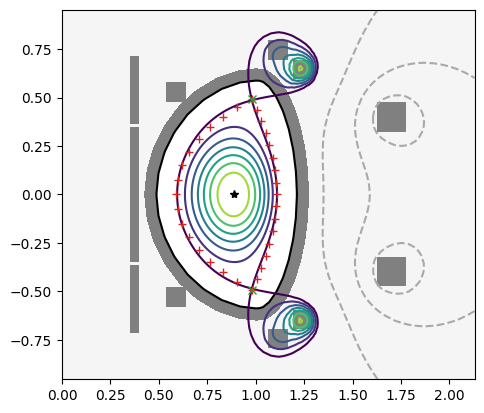

In [19]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax)
mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=4)
mygs.plot_constraints(fig,ax)
mygs.print_info()

0.016164598255227203


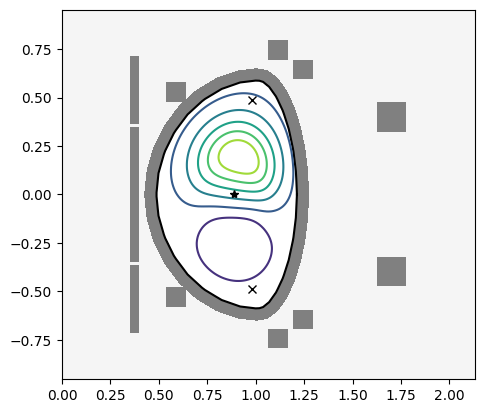

In [23]:
eig_vals, eig_vecs = mygs.eig_td(-1.E5,10, include_bounds = True)
eig_wall, eigvec_wall = mygs.eig_wall()
fig, ax = plt.subplots()
mygs.plot_machine(fig,ax)
mygs.plot_psi(fig,ax,psi = eig_vecs[0,:], normalized = False)
print(1/eig_wall[1,0])


In [22]:
print(-eig_vals[0,0]/eig_vals[1,0])

3.1924198920980933


#----------------------------------------------
OpenFUSIONToolkit Initialized
Development branch:   main
Revision id:          11ca7a7
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  4.064E+00
    # of points  =    4019
    # of edges   =   11948
    # of cells   =    7930
    # of boundary points =     106
    # of boundary edges  =     106
    # of boundary cells  =     106
  Resolution statistics:
    hmin =  4.899E-03
    hrms =  3.647E-02
    hmax =  1.085

 "none"
Flux surfaces from 600x600 gEQDSK
Levels based on psi ...
Grid diagonal resolution: 0.0025365011216131003 [m]
Cropping tables ...
Find magnetic axis ...
Find separatrix ...
Tracing flux surfaces ...
  > Took 0:00:01.685918
Find Br, Bz, F on flux surfaces ...
  > Took 0:00:00.986951
Flux surface averaging ...
  > Took 0:00:01.247783
Geometric quantities ...
  > Took 0:00:03.353340
[0.92698507 0.3872483 ]
[ 0.92696484 -0.38729464]
hi
#----------------------------------------------
OpenFUSIONToolkit Initialized
Development branch:   main
Revision id:          11ca7a7
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#-

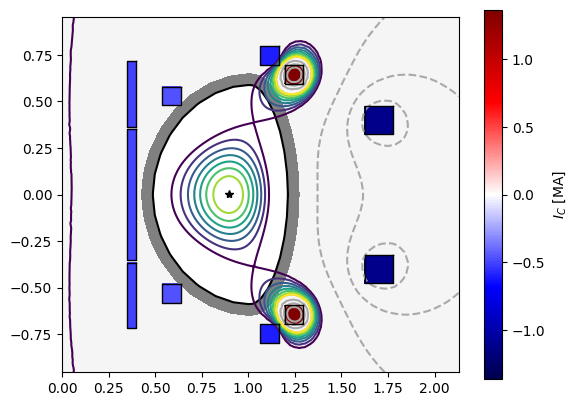

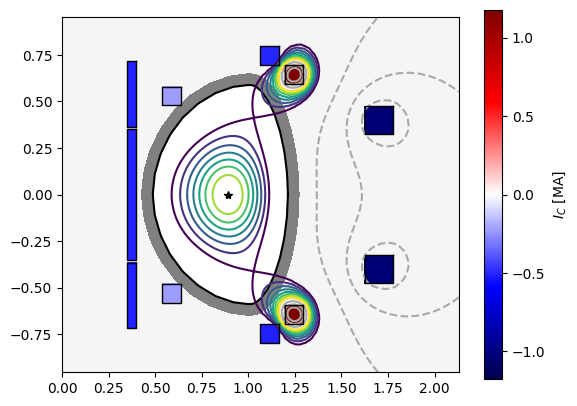

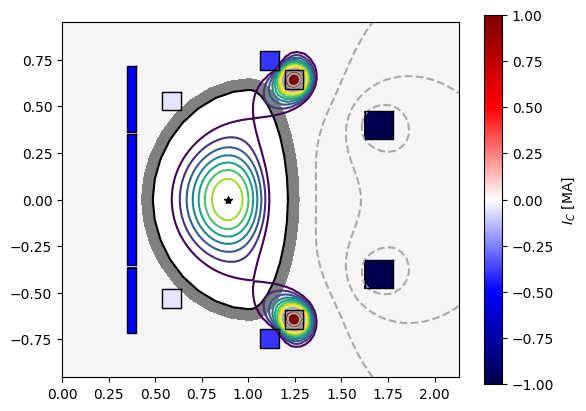

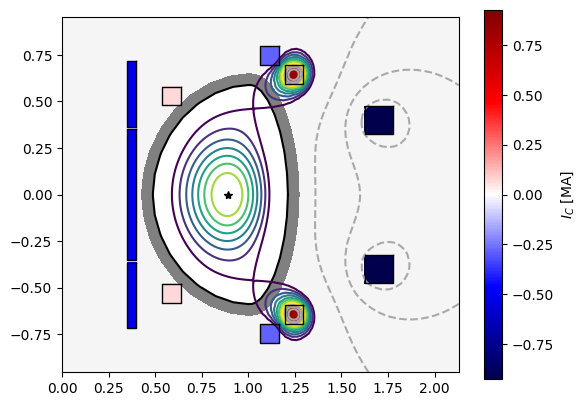

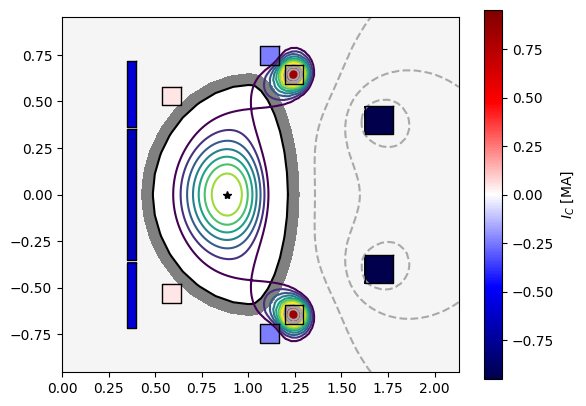

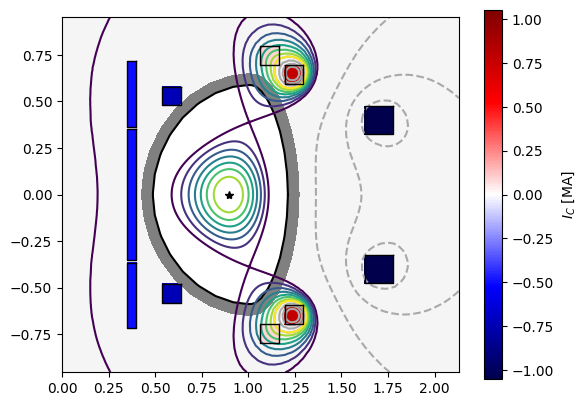

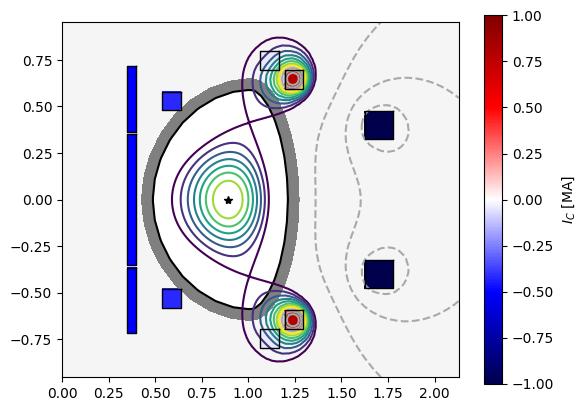

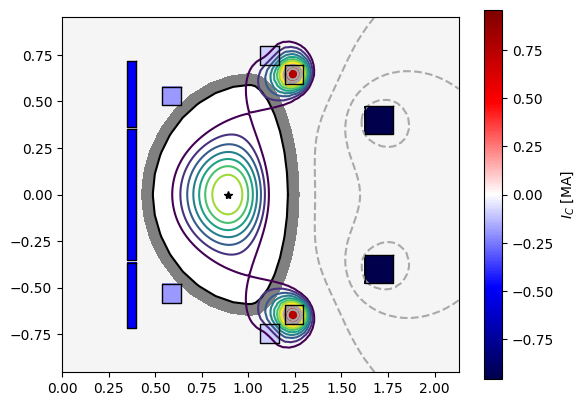

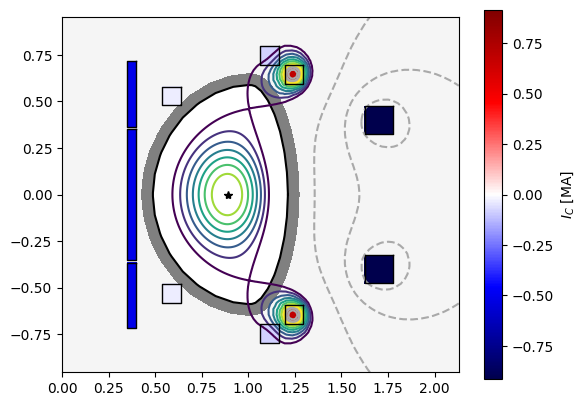

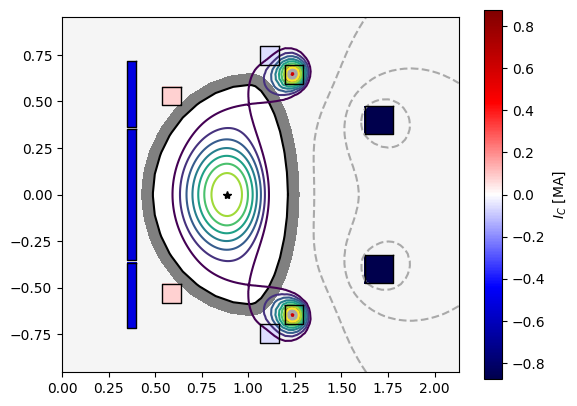

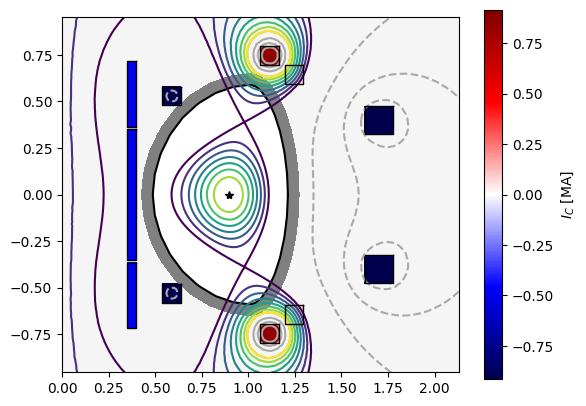

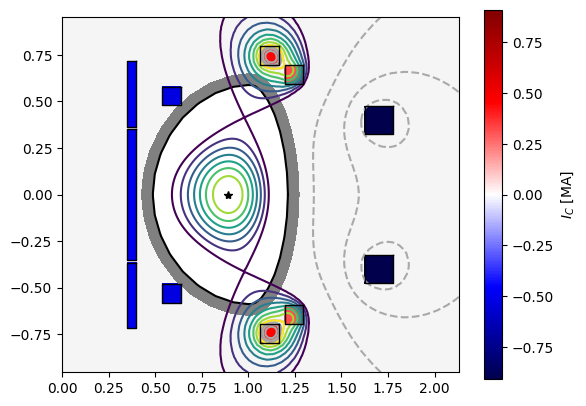

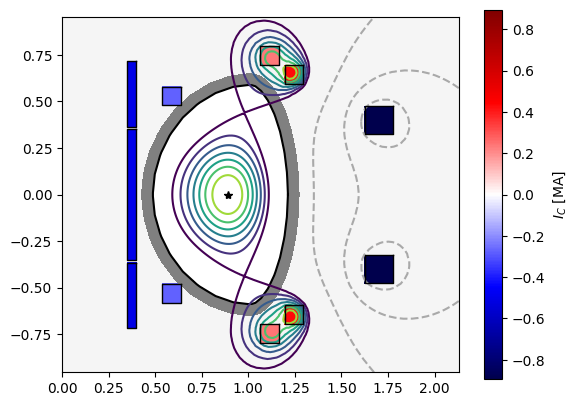

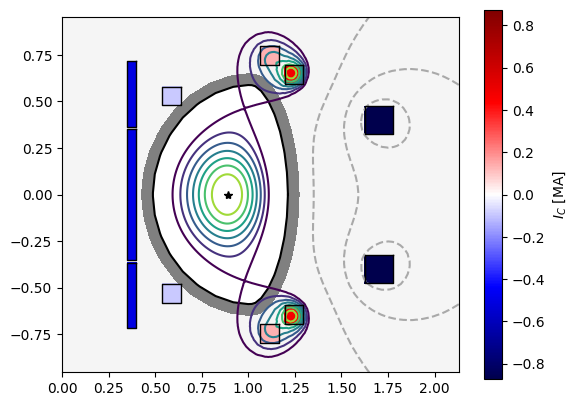

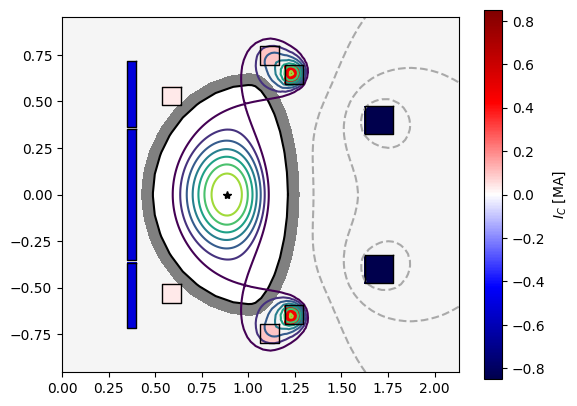

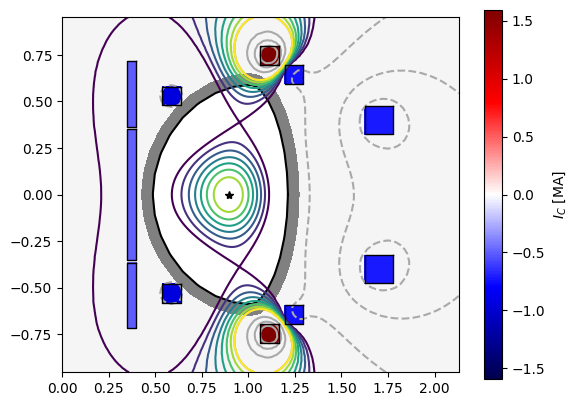

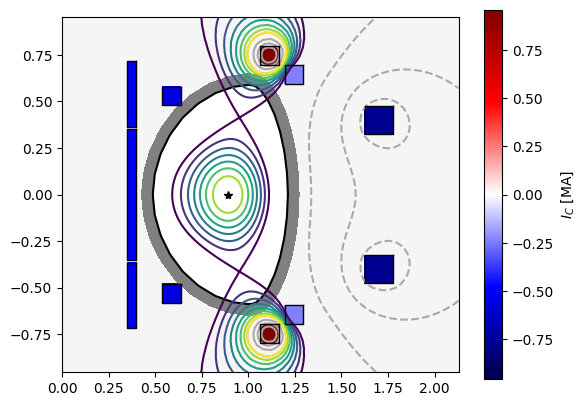

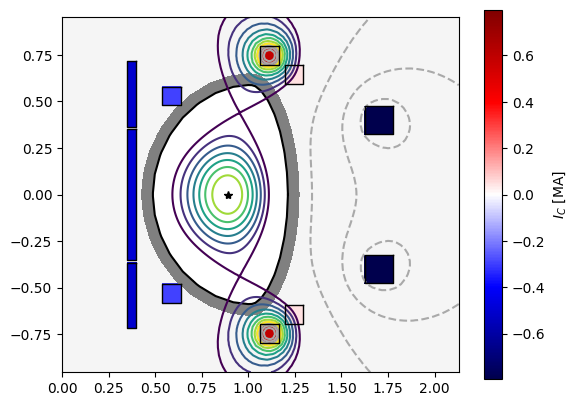

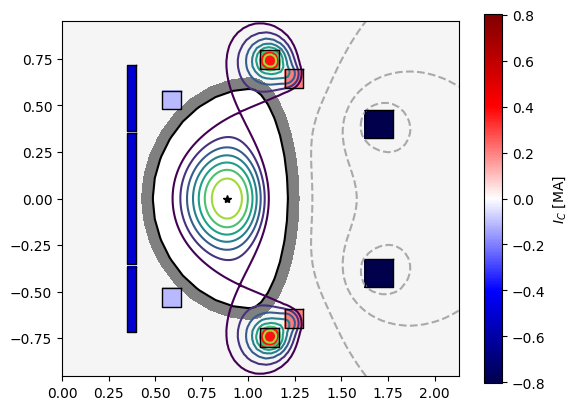

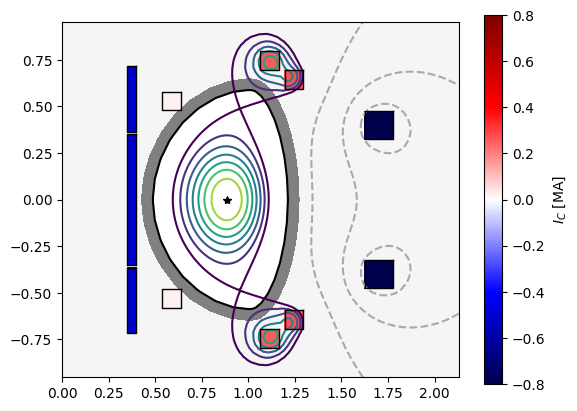

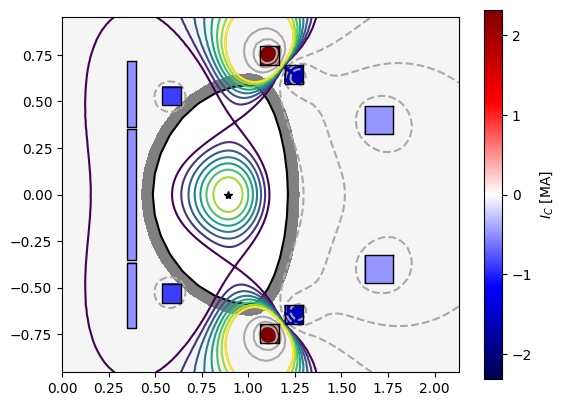

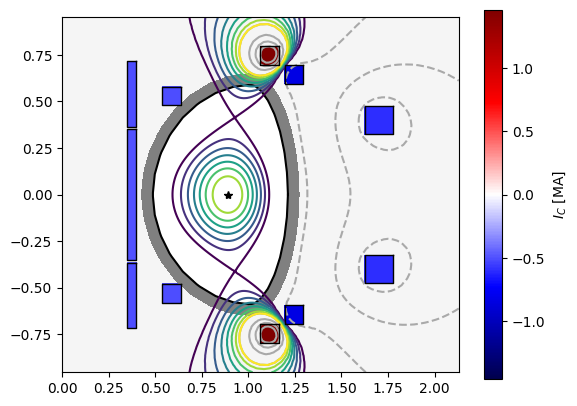

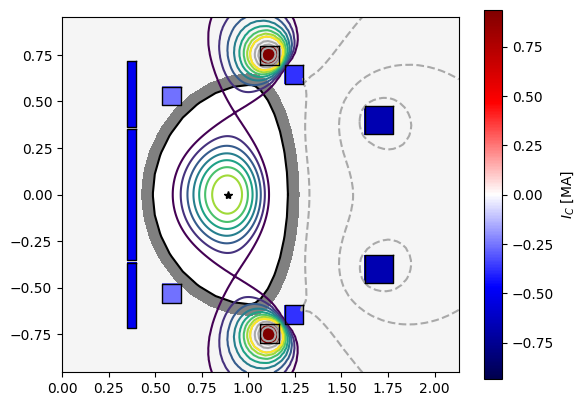

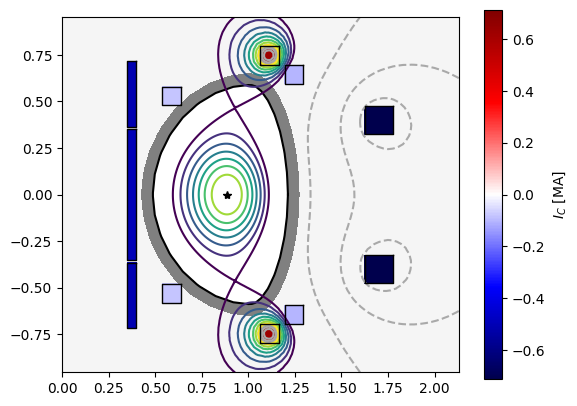

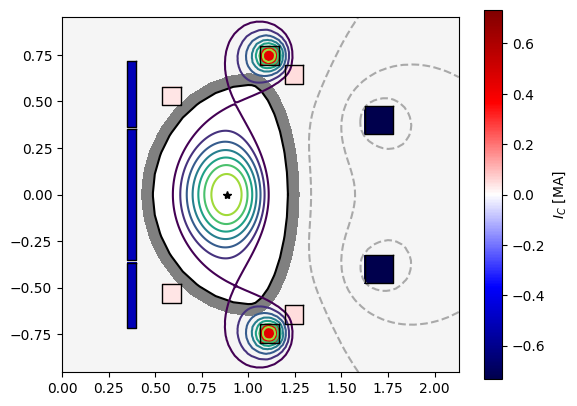

In [13]:
import copy
from omfit_classes.omfit_eqdsk import OMFITgeqdsk
d_omfit = []
e_omfit = []
d_tok = []
e_tok = []
q95 = []
betap = []
li = []
coil_currents = []
ds = np.linspace(-0.7, -.3, 5)
es = np.linspace(1.5, 1.9, 5)
dist = []
gammas = []
taus = []
eqdsks = []
lcfs = []

for d in ds: 
    for e in es:
        mygs = TokaMaker()
        mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
        mygs.setup_regions(cond_dict=cond_dict)
        mygs.setup(order = 2, F0 =0.8*3) ## F0 = B0 * R0

        coil_reg_mat = np.zeros((mygs.ncoils+1,mygs.ncoils+1), dtype=np.float64)
        targets = np.zeros(mygs.ncoils+1)
        coil_weights = 0.5*np.ones(mygs.ncoils+1)

        #Set target values for CS coils
        coil_reg_mat[0,0] = 1
        coil_reg_mat[1,1] = 1
        coil_reg_mat[2,2] = 1
        targets[0] = -5E5
        targets[1] = -5E5 
        targets[2] = -5E5

        #Enforce up/down symmetry in PF coils
        coil_reg_mat[3,3] = 1
        coil_reg_mat[3,7] = -1
        coil_reg_mat[4,4] = 1
        coil_reg_mat[4,8] = -1
        coil_reg_mat[5,5] = 1
        coil_reg_mat[5,9] = -1
        coil_reg_mat[6,6] = 1
        coil_reg_mat[6,10] = -1
        mygs.set_coil_reg(coil_reg_mat, targets, coil_weights)

        #Set upper bound on coil currents
        coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
        coil_bounds[:,0] = -1.E11; coil_bounds[:,1] = 1.E11
        mygs.set_coil_bounds(coil_bounds)

        # Define shape of P' anf FF' profiles
        n_sample = 40
        psi_sample = np.linspace(0.0,1.0,n_sample)
        # Set F*F' profile
        alpha = 2
        gamma = 3
        ffp_prof = {
            'type': 'linterp',
            'x': psi_sample,
            'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
        }
        ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)
        # Set P' profile
        alpha = 2
        gamma = 3
        pp_prof = {
            'type': 'linterp',
            'x': psi_sample,
            'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
        }
        pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)

        mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

        # set global targets
        Ip_target = 1E6
        mygs.set_targets(Ip = Ip_target, Ip_ratio=1.0)

        # set boundary/saddle point targets
        r, z, zeff = boundaryShape(kapu = e, kapl = e, delu = d, dell = d, zetail = 0, zetaiu = 0, zetaou = 0, zetaol = 0, a = 0.2588, eps = 0.2588/0.85, zoffset = 0, upnull = True, lonull = True, npts = 8)
        boundary = np.column_stack((r,z))
        x_points = np.zeros((2,2))
        x_points[0,:] = boundary[np.argmin(boundary[:,1]),:]
        x_points[1,:] = boundary[np.argmax(boundary[:,1]),:]
        x_weights = 5*np.ones(2)
        mygs.set_saddles(x_points, x_weights)
        isoflux_weights = 10*np.ones(32)

        if d < -0.65 and e > 1.85:
            isoflux_weights = 30*np.ones(32)
            print('catch')
        
        mygs.set_isoflux(boundary, isoflux_weights)

        #find equilibrium
        mygs.init_psi(0.68,0,0.2, 1.8,0.3)
        mygs.settings.maxits = 100
        mygs.update_settings()
        mygs.solve()

        #plot equilibrium
        fig, ax = plt.subplots(1,1)
        mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
        mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=4)
        
        for key, coil in coils.items():
            plt.plot(corners(coil['rc'],coil['zc'],coil['w'],coil['h'])[:,0],corners(coil['rc'],coil['zc'],coil['w'],coil['h'])[:,1], color = 'k', linewidth = 1)

        #save as eqdsk
        mygs.save_eqdsk('temp', lcfs_pad = .001, nr = 600, nz = 600)

        eqdsk = OMFITgeqdsk('temp')
        d_omfit.append(eqdsk['fluxSurfaces']['geo']['delta'][-1])    
        e_omfit.append(eqdsk['fluxSurfaces']['geo']['kap'][-1])
        
        point, distance = closest(read_eqdsk('temp')['rzout'], lim2)
        dist.append(distance)

        lcfs.append(read_eqdsk('temp')['rzout'])
        stats = mygs.get_stats()
        q95.append(stats['q_95'])
        betap.append(stats['beta_pol'])
        li.append(stats['l_i'])
        d_tok.append(stats['delta'])
        e_tok.append(stats['kappa'])

        eig_vals, eig_vecs = mygs.eig_td(-1.E5,10, include_bounds = True)
        gammas.append(eig_vals[0,0])

        eig_wall, eigvec_wall = mygs.eig_wall()
        taus.append(1/eig_wall[1][0])

        #extract coil currents
        current,currentmap = mygs.get_coil_currents()
        coil_currents.append(current)
        

        mygs.reset()

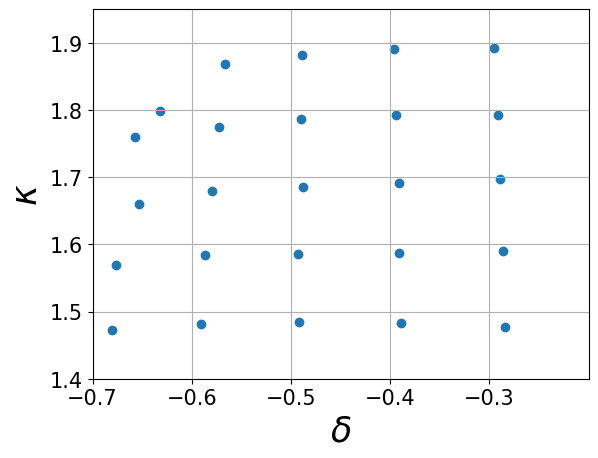

In [14]:
#OMFIT geometry calcs
plt.scatter(d_omfit, e_omfit)
plt.xlabel(r'$\delta$', size = 25)
plt.ylabel(r'$\kappa$', size = 25)
plt.xlim([-0.7, -0.2])
plt.ylim([1.4, 1.95])
plt.xticks(np.linspace(-0.7, -0.3, 5),size = 15)
plt.yticks(size = 15)
plt.grid()

In [15]:
print(dist)

[10.085948795498112, 10.076543882690665, 10.012940846559841, 9.96652885618355, 10.484024858069116, 10.184412377434922, 10.26923585723581, 10.233064904581282, 10.210193896914436, 9.95722973220862, 10.147613975098938, 10.290563434979875, 10.28382799370883, 10.29439890060927, 10.303568898718876, 10.12750189233071, 10.182182059661557, 10.24287189091021, 10.290612864641632, 10.332308858902849, 9.970527689420983, 10.071056288585282, 10.168557906886779, 10.260731897260682, 10.011268975582295]


In [16]:
gamma = np.array(gammas)
tau = np.array(taus)

In [17]:
print(gamma*tau*-1)
print(gamma)
print(tau)

[ 3.37830285  5.57160944  9.84968892 18.66834816 44.61699337  3.03950954
  4.7981858   8.41511081 15.55423723 33.40121371  2.53525627  4.03504874
  6.87031018 12.68610848 25.14683012  2.14284692  3.40983186  5.65419859
 10.24799271 19.53918042  1.68680807  2.90519948  4.93422402  8.76399567
 15.81745539]
[ -208.99392605  -344.67973509  -609.33706859 -1154.8909456
 -2760.16716692  -188.03495684  -296.83297563  -520.58892406
  -962.24087906 -2066.31882708  -156.84004209  -249.62258096
  -425.02201857  -784.80815172 -1555.67306569  -132.5641927
  -210.94442339  -349.78899559  -633.97756905 -1208.76375096
  -104.35199458  -179.7260553   -305.24878778  -542.1721918
  -978.52449798]
[0.0161646 0.0161646 0.0161646 0.0161646 0.0161646 0.0161646 0.0161646
 0.0161646 0.0161646 0.0161646 0.0161646 0.0161646 0.0161646 0.0161646
 0.0161646 0.0161646 0.0161646 0.0161646 0.0161646 0.0161646 0.0161646
 0.0161646 0.0161646 0.0161646 0.0161646]


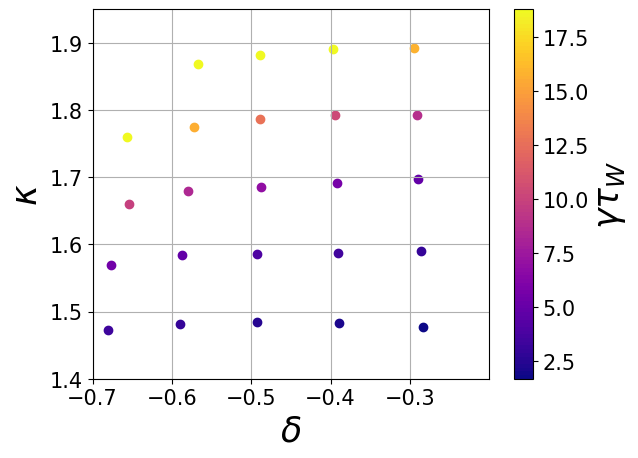

In [18]:
gt = np.array(gamma*tau*-1)
norm = plt.Normalize(np.min(gt), 18.78636067)
cmap = mpl.cm.plasma(np.linspace(0,1,100))
cmap = mpl.colors.ListedColormap(cmap[:,:-1])
c = cmap(norm(gt))

for i in range(25):
    if i is not 4:
        plt.scatter(d_omfit[i], e_omfit[i], color = c[i])
plt.xlabel(r'$\delta$', size = 25)
plt.ylabel(r'$\kappa$', size = 25)
plt.xlim([-0.7, -0.2])
plt.ylim([1.4, 1.95])
plt.xticks(np.linspace(-0.7, -0.3, 5),size = 15)
plt.yticks(size = 15)
plt.grid()
sm = plt.cm.ScalarMappable(cmap=cmap, norm = norm)
cb = plt.colorbar(sm)
cb.set_label(label=r'$\gamma \tau_{W}$', size = 25)
cb.ax.tick_params(labelsize=15)

(array([-0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

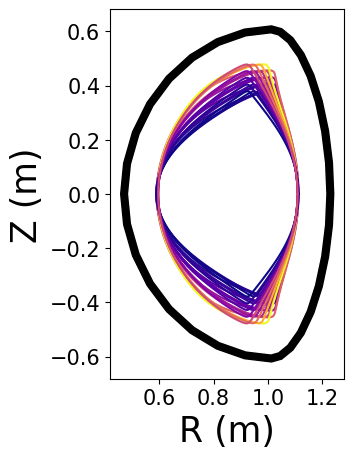

In [18]:
fig, ax = plt.subplots()
plt.fill(vv2[:,0], vv2[:,1], color = 'k')
plt.fill(lim2[:,0], lim2[:,1], color = 'w')
for i in range(25):
    if i is not 4:
        plt.plot(lcfs[i][:,0], lcfs[i][:,1], color = c[i])

plt.gca().set_aspect(aspect = 1)

plt.xlabel(r'R (m)', size = 25)
plt.ylabel(r'Z (m)', size = 25)
plt.xticks(size = 15)
plt.yticks(size = 15)



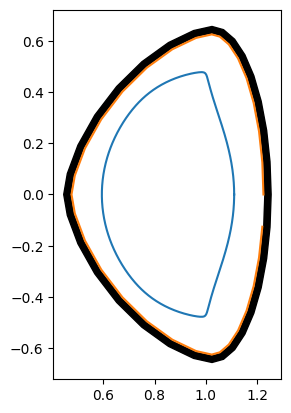

In [41]:
plt.fill(vv_outer[:,0], vv_outer[:,1], color = 'k')
plt.fill(vv_inner[:,0], vv_inner[:,1], color = 'w')
plt.plot(lcfs[9][:,0], lcfs[9][:,1])
plt.gca().set_aspect(aspect = 1)
r, z, zeff = boundaryShape(kapu = 1.9, kapl = 1.9, delu = -0.4, dell = -0.4, zetail = 0, zetaiu = 0, zetaou = 0, zetaol = 0, a = 0.2588, eps = 0.2588/0.85, zoffset = 0, upnull = True, lonull = True, npts = 8)
#plt.plot(r,z)
plt.plot(vv_inner[:,0], vv_inner[:,1])


[ 0.58817178 -0.00159887]
[1.11205718e+00 2.77576310e-07]
[1.11268431e+00 2.20212768e-05]
[ 1.11302479e+00 -1.30841265e-05]
[ 1.10790041e+00 -4.08556221e-05]
[ 0.58916904 -0.00159584]
[1.11011454e+00 9.90473136e-06]
[1.11046644e+00 2.06847842e-05]
[ 1.11065945e+00 -6.38112665e-06]
[0.72391253 0.34449303]
[ 0.58874487 -0.00160874]
[1.10992305e+00 1.85620137e-05]
[1.10996686e+00 4.29855656e-06]
[ 1.10984826e+00 -1.80118489e-05]
[ 1.10971866e+00 -1.86960111e-06]
[1.11158310e+00 1.55488303e-05]
[1.11103047e+00 8.49240256e-06]
[1.11042750e+00 4.43163697e-06]
[ 1.10992997e+00 -2.86898744e-05]
[1.10950775e+00 2.94042224e-05]
[ 1.11320405e+00 -4.55624962e-06]
[1.11218805e+00 5.25715964e-06]
[ 1.11120766e+00 -1.82625314e-05]
[ 1.11031689e+00 -1.07012131e-05]
[0.87047615 0.45524187]


([<matplotlib.axis.YTick at 0x130176340>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

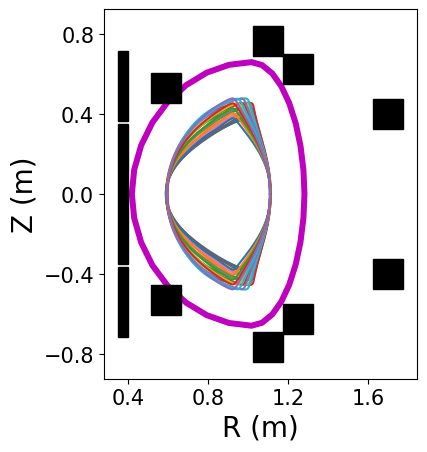

In [127]:
r,z,zeff= boundaryShape(kapu = 1.55, kapl = 1.55, delu = -0.4, dell = -0.4, zetail = -.03, zetaiu = -.03, zetaou = -.03, zetaol = -.03, a = 0.413, eps = 0.413/0.85, zoffset = 0, upnull = False, lonull = False, npts = 8)
lim1 = np.column_stack((r,z))
vv1 = resize_polygon(lim1, 0.03)

lim2 = resize_polygon(lim1, -0.05)
vv2 = resize_polygon(lim2, 0.03)

lim3 = resize_polygon(lim1, -0.1)
vv3 = resize_polygon(lim3, 0.03)

plt.fill(vv1[:,0], vv1[:,1], color = 'm')
plt.fill(lim1[:,0], lim1[:,1], color = 'w')
dist = []
for l in lcfs:
    point, distance = closest(l,lim3)
    dist.append(distance)
    #plt.scatter(point[0], point[1])
    print(point)
    plt.plot(l[:,0], l[:,1])


plt.gca().set_aspect(aspect = 1)

for key, coil in coils.items():
    plt.fill(corners(coil['rc'],coil['zc'],coil['w'],coil['h'])[:,0],corners(coil['rc'],coil['zc'],coil['w'],coil['h'])[:,1], color = 'k')

plt.xlabel(r'R (m)', size = 20)
plt.ylabel(r'Z (m)', size = 20)
plt.xticks(np.linspace(0.4, 1.6, 4),size = 15)
plt.yticks(np.linspace(-0.8, 0.8, 5),size = 15)

[5.072052622752913, 5.085513711904436, 5.022801194563968, 4.988752883409007, 5.501192228938083, 5.171721063071735, 5.279777804733826, 5.2445881197351945, 5.2252867507918905, 5.17598646268617, 5.129364008892966, 5.298927036940143, 5.294545729278324, 5.306406017522146, 5.319365715114244, 5.132921947334049, 5.188184781333638, 5.248481730538308, 5.298235488605177, 5.3404575213177345, 4.970826732709936, 5.0724267390717825, 5.1704660343528674, 5.259542820693631, 5.078966697991089]


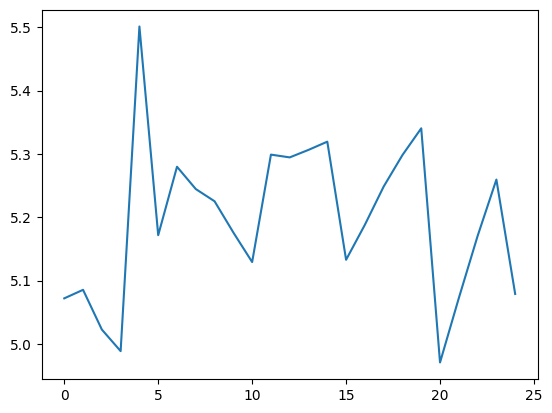

In [115]:
plt.plot(dist)
print(dist)

In [19]:
print(d_omfit)

[-0.6749524798749398, -0.678871187456987, -0.6635694051858014, -0.6465838561649153, -0.629702389371112, -0.5878151559874114, -0.5892356733732466, -0.5793812852700555, -0.5778649808417444, -0.5720431937847921, -0.4922759619864464, -0.49537528122331903, -0.48809804165915827, -0.4869901849908661, -0.4967125040518061, -0.3867284606499243, -0.3908768305518397, -0.39133914857819385, -0.393949049712552, -0.39894248483316863, -0.28670537607658814, -0.2834596390977844, -0.28674275160547724, -0.29081939239731186, -0.300419545387135]


In [20]:
print(e_omfit)

[1.4707196691000628, 1.5706930994507085, 1.6636449894639505, 1.7568393135419949, 1.7978078252677714, 1.4813374617153479, 1.5834954032313777, 1.679744167108638, 1.7768508083988566, 1.870079884155238, 1.4839192181328136, 1.5895651466845362, 1.6871224540633285, 1.7860239329302179, 1.8862750440326155, 1.4778488692523848, 1.590126838271416, 1.6897262591663433, 1.7931185932136315, 1.8940516893588253, 1.4814730712292983, 1.5877336640441675, 1.69203180881895, 1.7967159776459367, 1.8982188882826105]


In [ ]:
gt = np.array(gamma*tau*-1)
norm = plt.Normalize(np.min(gt), 7.73073782)
cmap = mpl.cm.plasma(np.linspace(0,1,100))
cmap = mpl.colors.ListedColormap(cmap[:,:-1])
c = cmap(norm(gt))

for i in range(25):
    if i is not 4:
        plt.scatter(d_omfit[i], e_omfit[i], color = [])
plt.xlabel(r'$\delta$', size = 25)
plt.ylabel(r'$\kappa$', size = 25)
plt.xlim([-0.7, -0.2])
plt.ylim([1.4, 1.95])
plt.xticks(np.linspace(-0.7, -0.3, 5),size = 15)
plt.yticks(size = 15)
plt.grid()
sm = plt.cm.ScalarMappable(cmap=cmap, norm = norm)
cb = plt.colorbar(sm)
cb.set_label(label=r'$\gamma \tau_{W}$', size = 25)
cb.ax.tick_params(labelsize=15)

In [40]:
coil_currents = np.array(coil_currents)
print(np.max(coil_currents[:,6]))
print(np.min(coil_currents[:,6]))

-480854.1751664901
-1124530.8068815435


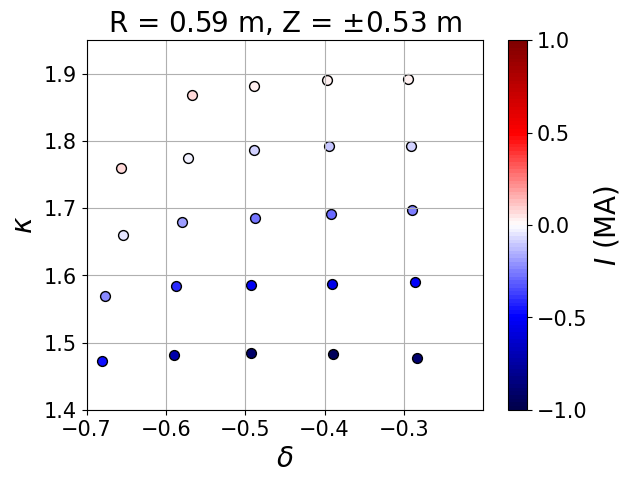

In [59]:
gt = np.array(gamma*tau*-1)
norm = plt.Normalize(-1, 1)
cmap = mpl.cm.seismic(np.linspace(0,1,100))
cmap = mpl.colors.ListedColormap(cmap[:,:-1])
c = cmap(norm(coil_currents[:,3]/1E6))

for i in range(25):
    if i is not 4:
        plt.scatter(d_omfit[i], e_omfit[i], color = c[i], edgecolors = 'k', s = 50)
plt.xlabel(r'$\delta$', size = 20)
plt.ylabel(r'$\kappa$', size = 20)
plt.xlim([-0.7, -0.2])
plt.ylim([1.4, 1.95])
plt.xticks(np.linspace(-0.7, -0.3, 5),size = 15)
plt.yticks(size = 15)
plt.grid()
plt.title(r'R = 0.59 m, Z = $\pm$0.53 m', size = 20)
sm = plt.cm.ScalarMappable(cmap=cmap, norm = norm)
cb = plt.colorbar(sm, ticks = [-1, -.5, 0, .5, 1])
cb.set_label(label=r'$I$ (MA)', size = 20)
cb.ax.tick_params(labelsize=15)

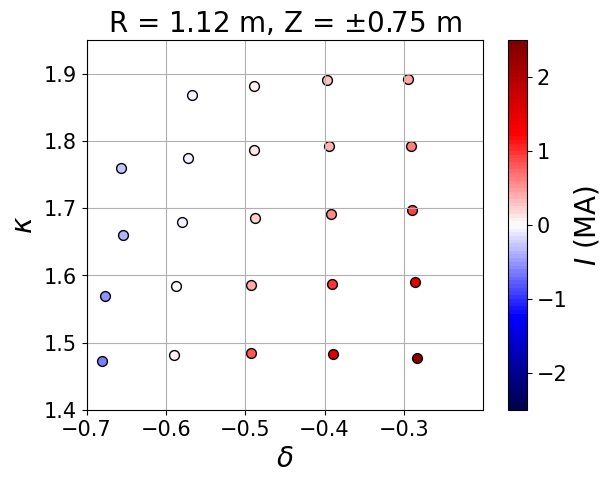

In [66]:
gt = np.array(gamma*tau*-1)
norm = plt.Normalize(-2.5, 2.5)
cmap = mpl.cm.seismic(np.linspace(0,1,100))
cmap = mpl.colors.ListedColormap(cmap[:,:-1])
c = cmap(norm(coil_currents[:,4]/1E6))

for i in range(25):
    if i is not 4:
        plt.scatter(d_omfit[i], e_omfit[i], color = c[i], edgecolors = 'k', s = 50)
plt.xlabel(r'$\delta$', size = 20)
plt.ylabel(r'$\kappa$', size = 20)
plt.xlim([-0.7, -0.2])
plt.ylim([1.4, 1.95])
plt.xticks(np.linspace(-0.7, -0.3, 5),size = 15)
plt.yticks(size = 15)
plt.grid()
plt.title(r'R = 1.12 m, Z = $\pm$0.75 m', size = 20)
sm = plt.cm.ScalarMappable(cmap=cmap, norm = norm)
cb = plt.colorbar(sm)
cb.set_label(label=r'$I$ (MA)', size = 20)
cb.ax.tick_params(labelsize=15)

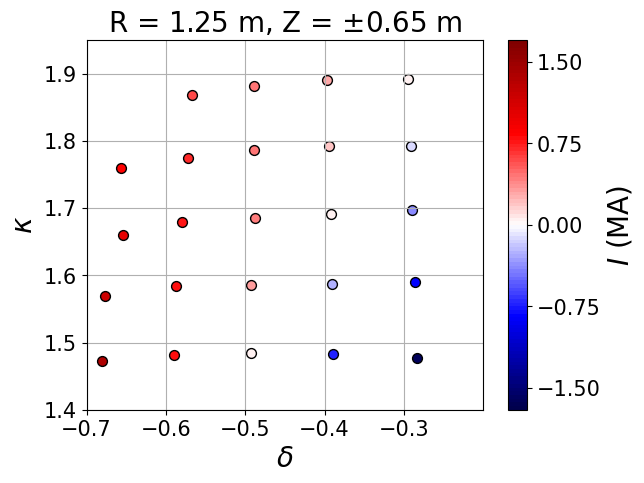

In [67]:
gt = np.array(gamma*tau*-1)
norm = plt.Normalize(-1.7, 1.7)
cmap = mpl.cm.seismic(np.linspace(0,1,100))
cmap = mpl.colors.ListedColormap(cmap[:,:-1])
c = cmap(norm(coil_currents[:,5]/1E6))

for i in range(25):
    if i is not 4:
        plt.scatter(d_omfit[i], e_omfit[i], color = c[i], edgecolors = 'k', s = 50)
plt.xlabel(r'$\delta$', size = 20)
plt.ylabel(r'$\kappa$', size = 20)
plt.xlim([-0.7, -0.2])
plt.ylim([1.4, 1.95])
plt.xticks(np.linspace(-0.7, -0.3, 5),size = 15)
plt.yticks(size = 15)
plt.title(r'R = 1.25 m, Z = $\pm$0.65 m', size = 20)
plt.grid()
sm = plt.cm.ScalarMappable(cmap=cmap, norm = norm)
cb = plt.colorbar(sm, ticks = [-1.5, -0.75, 0, 0.75, 1.5])
cb.set_label(label=r'$I$ (MA)', size = 20)
cb.ax.tick_params(labelsize=15)

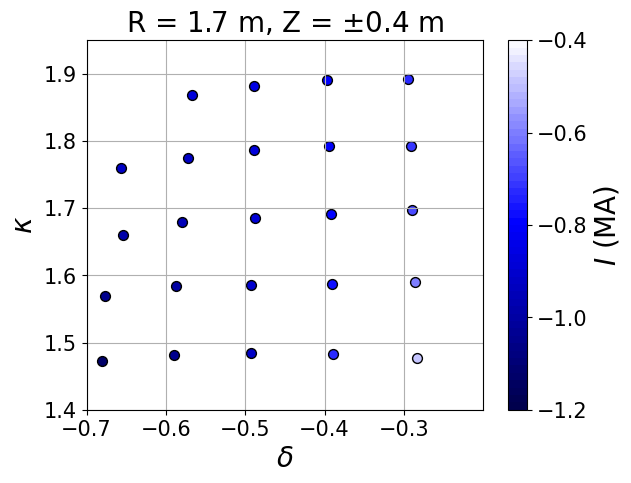

In [64]:
gt = np.array(gamma*tau*-1)
norm = plt.Normalize(-1.2, -.4)
cmap = mpl.cm.seismic(np.linspace(0,1,100))
cmap = mpl.colors.ListedColormap(cmap[:50,:-1])
c = cmap(norm(coil_currents[:,6]/1E6))

for i in range(25):
    if i is not 4:
        plt.scatter(d_omfit[i], e_omfit[i], color = c[i], edgecolors = 'k', s = 50)
plt.xlabel(r'$\delta$', size = 20)
plt.ylabel(r'$\kappa$', size = 20)
plt.xlim([-0.7, -0.2])
plt.ylim([1.4, 1.95])
plt.xticks(np.linspace(-0.7, -0.3, 5),size = 15)
plt.yticks(size = 15)
plt.title(r'R = 1.7 m, Z = $\pm$0.4 m', size = 20)
plt.grid()
sm = plt.cm.ScalarMappable(cmap=cmap, norm = norm)
cb = plt.colorbar(sm, ticks = [-0.4, -0.6, -0.8, -1.0, -1.2])
cb.set_label(label=r'$I$ (MA)', size = 20)
cb.ax.tick_params(labelsize=15)